<a href="https://colab.research.google.com/github/Lim0703/2022-2-ML-Class/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%9B%90%EB%8B%AC%EB%9F%AC_%ED%99%98%EC%9C%A8_%EC%98%88%EC%B8%A1_LSTM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# 표준화
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()

# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원

# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [ ]:
# 하이퍼파라미터
input_data_column_cnt = 4  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수

seq_length = 28            # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율

epoch_num = 1000           # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률 (적당히 설정해놔야됨)

In [ ]:
raw_dataframe = pd.read_csv('/content/drive/MyDrive/exchange_rate.csv') #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력

# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['date'] # 위 줄과 같은 효과

df_info = raw_dataframe.values[1:].astype(np.float) # 환율 문자열을 부동소수점형으로 변환한다
print("df_info.shape: ", df_info.shape)
print("df_info[0]: ", df_info[0])
print('date 값 삭제 후 rea_dateframe.info')
raw_dataframe.info() # 데이터 정보 출력

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1665 non-null   object 
 1   usd     1665 non-null   float64
 2   cny     1665 non-null   float64
 3   jpy     1665 non-null   float64
 4   eur     1665 non-null   float64
dtypes: float64(4), object(1)
memory usage: 65.2+ KB
df_info.shape:  (1664, 4)
df_info[0]:  [1184.3   179.19  992.42 1282.36]
date 값 삭제 후 rea_dateframe.info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   usd     1665 non-null   float64
 1   cny     1665 non-null   float64
 2   jpy     1665 non-null   float64
 3   eur     1665 non-null   float64
dtypes: float64(4)
memory usage: 52.2 KB


<ipython-input-5-9ffcf6c8f207>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  df_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다


In [ ]:
# 데이터 전처리
# 가격과 거래량 수치의 차이가 많아나서 각각 별도로 정규화한다

# 가격형태 데이터들을 정규화한다
x = min_max_scaling(df_info) # 가격형태 데이터 정규화 처리
print("price.shape: ", df_info.shape)
print("price[0]: ", df_info[0])
print("x[0]: ", x[0])
print("="*100) # 화면상 구분용

y = x[:, [0]] # 타켓은 원달러 환율이다
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

price.shape:  (1664, 4)
price[0]:  [1184.3   179.19  992.42 1282.36]
x[0]:  [0.80227052 0.01424562 0.65183304 0.87915138]
y[0]:  [0.80227052]
y[-1]:  [0.99866717]


In [ ]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용

for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 환율(정답)
    if i is 0:
        print(_x, "->", _y) # 첫번째 행만 출력해 봄
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

[[0.80227052 0.01424562 0.65183304 0.87915138]
 [0.80493618 0.01407313 0.65554144 0.87523913]
 [0.8097971  0.01413585 0.66382852 0.88248346]
 [0.8143444  0.01412801 0.67387964 0.90111174]
 [0.81160034 0.01419858 0.67619249 0.90228777]
 [0.82132217 0.01559413 0.67892872 0.90281306]
 [0.82124377 0.01727193 0.67865431 0.9018252 ]
 [0.81959733 0.01764042 0.67790949 0.90368332]
 [0.82453664 0.0178913  0.67851319 0.90649011]
 [0.82320381 0.01730329 0.6857732  0.9104102 ]
 [0.82437984 0.01820491 0.6834525  0.90903033]
 [0.82234139 0.01756986 0.68020667 0.90889704]
 [0.82367422 0.01767962 0.68610249 0.90812086]
 [0.82234139 0.01730329 0.67893656 0.90496127]
 [0.81708847 0.01662903 0.66830527 0.89207984]
 [0.81018911 0.01548437 0.66502807 0.89001788]
 [0.81567724 0.0161351  0.66946561 0.89762286]
 [0.81536363 0.0161351  0.66765453 0.90015524]
 [0.82116537 0.01706024 0.67120613 0.91036316]
 [0.81944052 0.01679368 0.65257785 0.89717597]
 [0.81810769 0.0168956  0.65437326 0.90229561]
 [0.81701007 

<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-7-d1b3c1d3d540>:7: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if i is 0:


In [ ]:
# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size

# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.compat.v1.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.compat.v1.placeholder(tf.float32, [None, 1])
print("Y: ", Y)

# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.compat.v1.placeholder(tf.float32, [None, 1])
print("targets: ", targets)

predictions = tf.compat.v1.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)

Instructions for updating:
non-resource variables are not supported in the long term


X:  Tensor("Placeholder:0", shape=(?, 28, 4), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [ ]:
pip install tf-slim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 352 kB 3.9 MB/s 


In [ ]:
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(num_units=rnn_cell_hidden_dim,
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.compat.v1.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.compat.v1.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 환율 1개를 예측하기때문에 MANY-TO-ONE형태이다
from tf_slim.layers import layers as _layers
hypothesis = _layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

<ipython-input-11-c117ecffe2fe>:9: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  cell = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(num_units=rnn_cell_hidden_dim,
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 28, 20), dtype=float32)


/usr/local/lib/python3.8/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임

train = optimizer.minimize(loss)

# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [ ]:
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)

        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)

        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))

end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)

학습을 시작합니다...
epoch: 100, train_error(A): 0.027529427781701088, test_error(B): 0.06963489949703217, B-A: 0.04210547357797623
epoch: 200, train_error(A): 0.025179212912917137, test_error(B): 0.06684339046478271, B-A: 0.04166417568922043
epoch: 300, train_error(A): 0.021630477160215378, test_error(B): 0.06280974298715591, B-A: 0.041179265826940536
epoch: 400, train_error(A): 0.016189148649573326, test_error(B): 0.054939720779657364, B-A: 0.03875057399272919
epoch: 500, train_error(A): 0.011562674306333065, test_error(B): 0.03962121903896332, B-A: 0.028058543801307678
epoch: 600, train_error(A): 0.00979832373559475, test_error(B): 0.034152835607528687, B-A: 0.024354511871933937
epoch: 700, train_error(A): 0.008385996334254742, test_error(B): 0.027538394555449486, B-A: 0.01915239915251732
epoch: 800, train_error(A): 0.009069462306797504, test_error(B): 0.022461671382188797, B-A: 0.013392209075391293
epoch: 900, train_error(A): 0.007939237169921398, test_error(B): 0.022886214777827263, B-A: 

input_data_column_cnt: 4,output_data_column_cnt: 1,seq_length: 28,rnn_cell_hidden_dim: 20,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 1.0,epoch_num: 1000,learning_rate: 0.01,train_error: 0.0072253724,test_error: 0.020749439,min_test_error: 0.020749439


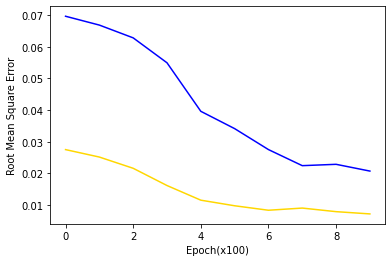

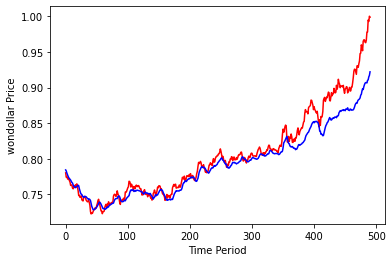

In [ ]:
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')

print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')

print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')

print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))

# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('wondollar Price')
plt.show()

In [ ]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)

# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})

print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(df_info,test_predict) # 금액데이터 역정규화한다
print("Tomorrow's wondollar price", test_predict[0]) # 예측한 환율을 출력한다

recent_data.shape: (1, 28, 4)
recent_data: [[[0.91391476 0.02625678 0.63327532 0.91766237]
  [0.92293097 0.02708784 0.63687396 0.91673723]
  [0.92575344 0.02689184 0.64352244 0.92291529]
  [0.92543983 0.02685264 0.64059805 0.92186471]
  [0.92191175 0.02642927 0.64127231 0.91886976]
  [0.91846207 0.02601374 0.63103302 0.91281714]
  [0.93037915 0.02652335 0.63531376 0.93016747]
  [0.93022235 0.02651551 0.63476495 0.93238624]
  [0.9283407  0.02633518 0.63138583 0.93350739]
  [0.93328002 0.02693104 0.62977859 0.92761157]
  [0.93727851 0.02769938 0.63138583 0.9289836 ]
  [0.94762756 0.0285618  0.63815975 0.94140245]
  [0.94809797 0.02861668 0.62331828 0.9364945 ]
  [0.95985825 0.0294007  0.62739518 0.96018754]
  [0.95664377 0.02920469 0.63274218 0.97018377]
  [0.95162605 0.02951046 0.6175479  0.94796469]
  [0.96487597 0.03026312 0.6368034  0.96286104]
  [0.96683601 0.03049832 0.63627811 0.96606768]
  [0.96683601 0.02965942 0.6385988  0.9688039 ]
  [0.96362154 0.02924389 0.63412206 0.9666164